In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd 

from tensorflow.keras import datasets, layers, models, regularizers, initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from skimage.io import imshow
from skimage.transform import rotate
from skimage.filters.edges import convolve

from skimage.io import imshow, imread
from skimage.transform import resize
from skimage.color import rgb2gray

import dill as pickle

np.random.seed(33)

In [2]:
df_test = pd.read_csv('data/test_labels.csv')
df_train = pd.read_csv('data/train_labels.csv')

bw_loaded = np.load('data/bw_images.npz')
X_train= bw_loaded['a']
X_test = bw_loaded['b']

col_loaded = np.load('data/color_images.npz')
X_color = col_loaded['b'].reshape(-1,80,60,3)

X_test = X_test.reshape(-1,80,60,1)
X_train = X_train.reshape(-1,80,60,1)

In [5]:
print(X_color.shape)
print(X_test.shape)

(6440, 80, 60, 3)
(6440, 80, 60, 1)


In [6]:
app_train = df_train[df_train.masterCategory=='Apparel']
app_train_idx = list(app_train.index)
X_train_app = X_train[app_train_idx]

app_test = df_test[df_test.masterCategory=='Apparel']
app_test_idx = list(app_test.index)
X_test_app = X_test[app_test_idx]
X_color_app = X_color[app_test_idx]

y_train0 = app_train.subCategory.copy().astype('category').cat.codes
y_test0 = app_test.subCategory.copy().astype('category').cat.codes

In [7]:
cnn_sub = load_model('json/cnn-apparel.h5')

W0731 21:02:09.788847 140426179729216 deprecation.py:506] From /home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0731 21:02:09.789915 140426179729216 deprecation.py:506] From /home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0731 21:02:09.790873 140426179729216 deprecation.py:506] From /home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tenso

In [8]:
y_true_app = y_test0
# get the predictions for the test data
predicted_classes = cnn_sub.predict_classes(X_test_app)

# get the indices to be plotted
correct = np.nonzero(predicted_classes==y_true_app)[0]
incorrect = np.nonzero(predicted_classes!=y_true_app)[0]

app_train.subCategory.value_counts().index
app_list = ['Bottomwear', 'Innerwear','Loungewear', 'Socks', 'Saree','Topwear']
from sklearn.metrics import classification_report
target_names = ["Class {}: {}".format(i, ix) for i, ix in enumerate(app_list)]
print(classification_report(y_true_app, predicted_classes, target_names=target_names))

                     precision    recall  f1-score   support

Class 0: Bottomwear       0.94      0.97      0.95       364
 Class 1: Innerwear       0.98      0.94      0.96       329
Class 2: Loungewear       0.88      0.59      0.70        95
     Class 3: Socks       0.98      0.99      0.98        92
     Class 4: Saree       0.98      0.92      0.95       134
   Class 5: Topwear       0.97      0.99      0.98      1589

           accuracy                           0.97      2603
          macro avg       0.95      0.90      0.92      2603
       weighted avg       0.96      0.97      0.96      2603



/home/ubuntu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


In [9]:
wrong_arr = np.array([predicted_classes[incorrect], y_true_app[incorrect]]).transpose()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [10]:
wrong_df = pd.DataFrame(wrong_arr, columns=['Predicted','True'])

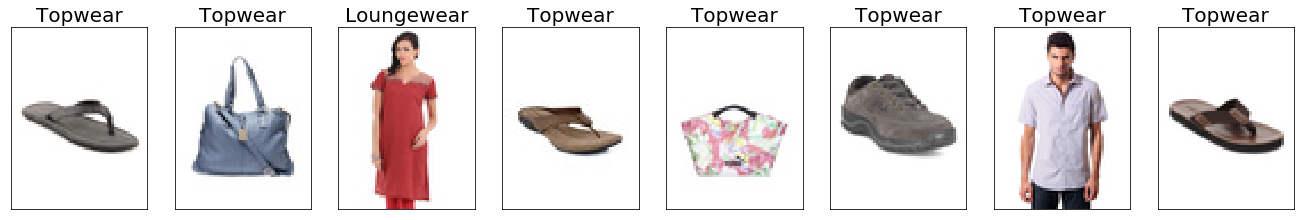

In [11]:
list_wrong = incorrect
cat_dict = {k:v for k, v in enumerate(app_list)}
wrong_cat = wrong_df.Predicted.apply(lambda x: cat_dict[x])
fig, axs = plt.subplots(1, 8, figsize=(23,4))
for i, ax in enumerate(axs.flatten()):
    ax.imshow( X_color[list_wrong[i]].reshape(80,60,3)/255 )
    #print(topwear_idx[i])
    ax.set_xticks([])
    ax.set_yticks([]);
    #ax.set_ylabel('{}')
    ax.set_title('{}'.format(wrong_cat[i]), fontsize=20)
plt.subplots_adjust(hspace = 0.7)

In [12]:
app_test.iloc[incorrect,:]

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
151,28487,Men,Apparel,Innerwear,Innerwear Vests,Grey,Summer,2016.0,Casual,Urban Yoga Men Printed Grey Innerwear T-shirt
200,55789,Women,Apparel,Loungewear and Nightwear,Nightdress,Black,Summer,2017.0,Casual,SDL by Sweet Dreams Women Black Nightdress
216,53475,Women,Apparel,Innerwear,Bra,Pink,Summer,2017.0,Casual,Amante Pink Full-Coverage Bra BCSB01
310,51801,Women,Apparel,Loungewear and Nightwear,Nightdress,Pink,Summer,2016.0,Casual,Bwitch Women Pink Nightdress
334,52405,Women,Apparel,Loungewear and Nightwear,Nightdress,Black,Winter,2015.0,Casual,Red Rose Women Black Nightdress
360,52407,Women,Apparel,Loungewear and Nightwear,Nightdress,Black,Winter,2015.0,Casual,Red Rose Women Black Nightdress
407,52378,Women,Apparel,Loungewear and Nightwear,Nightdress,Purple,Winter,2015.0,Casual,Red Rose Women Lavender Nightdress
442,52349,Women,Apparel,Loungewear and Nightwear,Nightdress,Pink,Summer,2017.0,Casual,Red Rose Women Pink Nightdress
487,54977,Women,Apparel,Loungewear and Nightwear,Lounge Pants,Blue,Summer,2017.0,Casual,Femella Women Blue Lounge Pants
696,45095,Women,Apparel,Loungewear and Nightwear,Night suits,Grey,Winter,2015.0,Casual,Bwitch Silver Pyjama Set


In [17]:
acc_train = df_train[df_train.masterCategory=='Accessories']
acc_train_idx = list(acc_train.index)
X_train_acc = X_train[acc_train_idx]

acc_test = df_test[df_test.masterCategory=='Accessories']
acc_test_idx = list(acc_test.index)
X_test_acc = X_test[acc_test_idx]
X_color_acc = X_color[acc_train_idx]

y_train_acc0 = acc_train.subCategory.copy().astype('category').cat.codes
y_test_acc0 = acc_test.subCategory.copy().astype('category').cat.codes

from tensorflow.keras.utils import to_categorical
y_train_acc = to_categorical(y_train_acc0)
y_test_acc = to_categorical(y_test_acc0)

print(y_train_acc.shape)
print(y_test_acc.shape)

IndexError: index 6441 is out of bounds for axis 0 with size 6440